# Zadanie: prognoza vs wartości prawdziwe
Pozostaw zbiór testowy jak obecnie. Zmień funkcję do backtestów oraz stworzenia zbiorów treningowego oraz testowego, tak aby nie ucinało pierwszych wartości ze zbioru testowego. Ze zbioru treningowego wyciągnij zbiór walidacyjny. Stwórz coś na wzór ‘siatki hiperparametrów’, tak jak dzieje się w GridSearch (Podpowiedź: Wystarczą pętle). Jako hiperparametry traktuj wartość dla zmiennej look_back oraz liczbę komórek w warstwie (units). Sprawdź zatem wszystkie architektury dla look_back z zakresu od 1 do 12 oraz units z zakresu 1 do 12. Wybierz model, który ma najniższą metrykę RMSE na zbiorze walidacyjnym i zwizualizuj prognozę vs wartości prawdziwe.

In [373]:
# przetwarzanie danych
import numpy as np
import pandas as pd

# przekształcanie – normalizacja danych
from sklearn.preprocessing import MinMaxScaler

# wizualizacja
import matplotlib.pyplot as plt

# sieci neuronowe
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU

# ewaluacja modelu
from sklearn.metrics import mean_squared_error

### Wczytanie i przygotowanie danych

In [374]:
# !wget --no-check-certificate "https://uploads.kodilla.com/bootcamp/ds/19/airline-passengers.csv" -O "/tmp/airline-passengers.csv"

In [375]:
dataset = pd.read_csv('airline-passengers.csv')
try:
  dataset['Month'] = pd.to_datetime(dataset['Month'])
  dataset.set_index(['Month'], inplace=True)
except KeyError:
  pass
dataset.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Wykres rzeczywisty

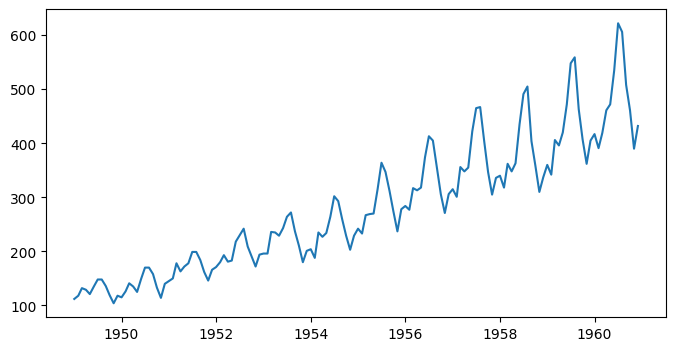

In [376]:
plt.figure(figsize=(8,4))
plt.plot(dataset['Passengers'])
plt.show()

### Podział danych na zbiór treningowy, walidacyjny i testowy

Moje wersje funkcji

In [377]:
# zbiór treningowy
train_size = int(len(dataset) * 0.70)

# zbiór treningowy - podzbiór treningowy i walidacyjny
train_valid_size = int(train_size * 0.3)
train_train_size = train_size-train_valid_size

look_back = None

In [378]:
train_size, train_train_size, train_valid_size, len(dataset)-train_size

(100, 70, 30, 44)

In [379]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [380]:
def create_dataset(df, train_size, lback=look_back, scaler_function=scaler):

  test_size = len(df) - train_size
  train, test = df[0:train_size,:].copy(), df[train_size-lback:,:].copy()
  train = scaler_function.fit_transform(train)
  test = scaler_function.transform(test)
  X_train, X_test, y_train, y_test = [], [], [], []

  # Tworzenie zbioru treningowego (nowa wersja)
  for i in range(len(train)-lback):
      a = train[i:(i+lback)]
      X_train.append(a)
      y_train.append(train[i+lback])
      
  # Tworzenie zbioru testowego (nowa wersja)
  for i in range(len(test)-lback):
      a = test[i:i+lback]
      X_test.append(a)
      y_test.append(test[i+lback])

  X_train, X_test = np.array(X_train), np.array(X_test)
  X_train, X_test = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])),\
                np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  y_train, y_test = np.array(y_train), np.array(y_test)

  return X_train, X_test, y_train, y_test

## Modele

#### Funkcja backtest - prediction vs true, metryka RMSE

In [381]:

def backtest(model, dataset, X_train, X_test, lback=look_back, plot_results=True):

  # predykcja na modelu treningowym
  prediction_train = scaler.inverse_transform(model.predict(X_train))
  # prediction_train = model.predict(X_train)
  prediction_train = pd.Series(prediction_train.flatten(),
                               index=dataset.index[lback:len(prediction_train)+lback])
  # predykcja na modelu testowym
  prediction_test = scaler.inverse_transform(model.predict(X_test))
  # prediction_test = model.predict(X_test)
  # prediction_test = pd.Series(prediction_test.flatten(),
  #                              index=dataset.index[len(prediction_train)+(2*lback+1):len(dataset)-1])
  # nowa wersja
  prediction_test = pd.Series(prediction_test.flatten(),
                               index=dataset.index[len(prediction_train)+lback:len(dataset)])

  if plot_results == True:
    # wizualizacja prognozy
    plt.figure(figsize=(8,4.5))
    plt.plot(dataset['Passengers'], color='blue', label='True values')
    plt.plot(prediction_train, color='green', label='Prediction - Train')
    plt.plot(prediction_test, color='red', label='Prediction - Test')
    plt.legend(loc = 'upper left')
    plt.show()

  # obliczenie RMSE
  rmse = mean_squared_error(dataset.loc[prediction_test.index, :],
                            prediction_test)**0.5
  print(f'\nRMSE TEST: {rmse}')
  
  return rmse

In [382]:
rnn_rmse = []
lstm_rmse = []
gru_rmse = []

### RNN

In [383]:
for units in range(1,12):
    for look_back in range(1,12):
        # look_back = 12
        X_train_valid, X_valid, y_train_valid, y_valid =\
            create_dataset(df=np.array(dataset[:train_size]), train_size=train_train_size, lback=look_back)
        model_rnn = Sequential()
        model_rnn.add(SimpleRNN(units=units, input_shape=(1,look_back)))
        model_rnn.add(Dense(1))
        model_rnn.compile(loss='mean_squared_error', optimizer='adam')
        model_rnn.fit(X_train_valid, y_train_valid, epochs=200, batch_size=1, verbose=0)
        rmse = backtest(model_rnn, dataset[:train_size], X_train_valid, X_valid, lback=look_back, plot_results=False)
        
        rnn_rmse.append(['rnn', units, look_back, rmse])

1/1 [==============================] - 0s 22ms/step

RMSE TEST: 42.042044600441606
1/1 [==============================] - 0s 28ms/step

RMSE TEST: 44.634148353492684
1/1 [==============================] - 0s 25ms/step

RMSE TEST: 51.76391512000708
1/1 [==============================] - 0s 26ms/step

RMSE TEST: 47.10248686076495
1/1 [==============================] - 0s 25ms/step

RMSE TEST: 53.49199485045342
1/1 [==============================] - 0s 131ms/step

RMSE TEST: 47.725949049685
1/1 [==============================] - 0s 23ms/step

RMSE TEST: 47.434462855101906
1/1 [==============================] - 0s 22ms/step

RMSE TEST: 41.159605182869214
1/1 [==============================] - 0s 22ms/step

RMSE TEST: 45.59984487529583
1/1 [==============================] - 0s 21ms/step

RMSE TEST: 51.641928199113806
1/1 [==============================] - 0s 21ms/step

RMSE TEST: 42.258240934165066
1/1 [==============================] - 0s 18ms/step

RMSE TEST: 45.60893028978608
1/1 [======

### LSTM

In [384]:
for units in range(1,12):
    for look_back in range(1,12):
        # look_back = 12
        X_train_valid, X_valid, y_train_valid, y_valid =\
            create_dataset(df=np.array(dataset[:train_size]), train_size=train_train_size, lback=look_back)

        model_lstm = Sequential()
        model_lstm.add(LSTM(units=units, input_shape=(1, look_back)))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mean_squared_error', optimizer='adam')
        # model_lstm.fit(X_train, y_train, epochs=20, batch_size=1, verbose=0)
        model_lstm.fit(X_train_valid, y_train_valid, epochs=200, batch_size=1, verbose=0)
        rmse = backtest(model_lstm, dataset[:train_size], X_train_valid, X_valid, lback=look_back, plot_results=False)

        lstm_rmse.append(['lstm', units, look_back, rmse])

1/1 [==============================] - 0s 25ms/step

RMSE TEST: 41.98412503885375
1/1 [==============================] - 0s 22ms/step

RMSE TEST: 43.183269105424955
1/1 [==============================] - 0s 20ms/step

RMSE TEST: 54.55509932074135
1/1 [==============================] - 0s 21ms/step

RMSE TEST: 55.39069196378893
1/1 [==============================] - 0s 25ms/step

RMSE TEST: 48.9953880717378
1/1 [==============================] - 0s 359ms/step

RMSE TEST: 54.79513507869058
1/1 [==============================] - 0s 21ms/step

RMSE TEST: 59.67264300871644
1/1 [==============================] - 0s 21ms/step

RMSE TEST: 56.139104300728896
1/1 [==============================] - 0s 20ms/step

RMSE TEST: 50.114928181855795
1/1 [==============================] - 0s 22ms/step

RMSE TEST: 51.317240153145065
1/1 [==============================] - 0s 19ms/step

RMSE TEST: 55.36631626110806
1/1 [==============================] - 0s 21ms/step

RMSE TEST: 41.895871424227096
1/1 [======

### GRU

In [385]:
for units in range(1,12):
    for look_back in range(1,12):
        # look_back = 12
        X_train_valid, X_valid, y_train_valid, y_valid =\
            create_dataset(df=np.array(dataset[:train_size]), train_size=train_train_size, lback=look_back)

        model_gru = Sequential()
        model_gru.add(GRU(units=units, input_shape=(1, look_back)))
        model_gru.add(Dense(1))
        model_gru.compile(loss='mean_squared_error', optimizer='adam')
        model_gru.fit(X_train_valid, y_train_valid, epochs=200, batch_size=1, verbose=0)
        rmse = backtest(model_gru, dataset[:train_size], X_train_valid, X_valid, lback=look_back, plot_results=False)
  
        gru_rmse.append(['gru', units, look_back, rmse])

1/1 [==============================] - 0s 19ms/step

RMSE TEST: 39.950306874497095
1/1 [==============================] - 0s 19ms/step

RMSE TEST: 49.43566003295345
1/1 [==============================] - 0s 19ms/step

RMSE TEST: 40.53258521469808
1/1 [==============================] - 0s 18ms/step

RMSE TEST: 52.33238845969234
1/1 [==============================] - 0s 19ms/step

RMSE TEST: 50.79827123603089
1/1 [==============================] - 0s 314ms/step

RMSE TEST: 47.1419607010297
1/1 [==============================] - 0s 19ms/step

RMSE TEST: 55.13373581334429
1/1 [==============================] - 0s 19ms/step

RMSE TEST: 45.71190904326545
1/1 [==============================] - 0s 18ms/step

RMSE TEST: 43.041440034621594
1/1 [==============================] - 0s 21ms/step

RMSE TEST: 46.23304439783924
1/1 [==============================] - 0s 19ms/step

RMSE TEST: 40.410417138838795
1/1 [==============================] - 0s 19ms/step

RMSE TEST: 34.89482868851405
1/1 [========

In [386]:
df = pd.concat([pd.DataFrame(rnn_rmse, columns=['model', 'units', 'look_back', 'rmse']), 
                pd.DataFrame(lstm_rmse, columns=['model', 'units', 'look_back', 'rmse']),
                pd.DataFrame(gru_rmse, columns=['model', 'units', 'look_back', 'rmse'])])


In [387]:
df

,model,units,look_back,rmse
0,rnn,1,1,42.042045
1,rnn,1,2,44.634148
2,rnn,1,3,51.763915
3,rnn,1,4,47.102487
4,rnn,1,5,53.491995
...,...,...,...,...
116,gru,11,7,51.861147
117,gru,11,8,52.166966
118,gru,11,9,62.374607
119,gru,11,10,57.050658


In [388]:
best_results = df.loc[df['rmse']==min(df['rmse'])]
best_results

,model,units,look_back,rmse
19,rnn,2,9,28.80937


In [391]:
best_results

,model,units,look_back,rmse
19,rnn,2,9,28.80937


In [398]:
best_results['model'].values[0], best_results['units'].values[0], best_results['look_back'].values[0]
# , int(best_results['units'][0]), int(best_results['look_back'][0])

('rnn', 2, 9)

In [399]:
best_model, best_units, best_look_back = \
    best_results['model'].values[0], best_results['units'].values[0], best_results['look_back'].values[0]

In [400]:
# do testów
X_train, X_test, y_train, y_test =\
    create_dataset(df=np.array(dataset), train_size=train_size, lback=best_look_back)

2/2 [==============================] - 0s 3ms/step


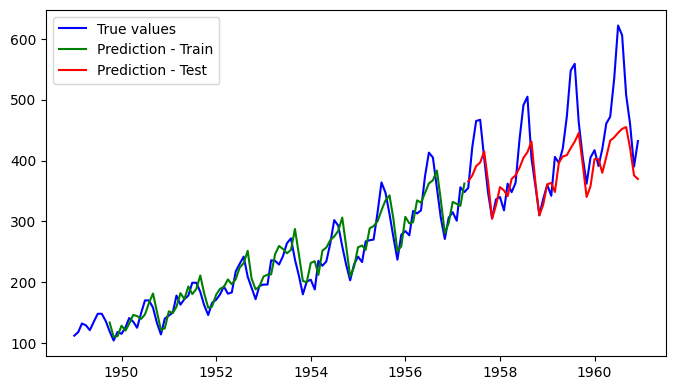


RMSE TEST: 59.82044024993784


In [401]:
if best_model == 'rnn':
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(units=best_units, input_shape=(1, best_look_back)))
    model_rnn.add(Dense(1))
    model_rnn.compile(loss='mean_squared_error', optimizer='adam')
    # model_rnn.fit(X_train, y_train, epochs=200, batch_size=1, verbose=0)
    model_rnn.fit(X_train, y_train, epochs=200, batch_size=1, verbose=0)
    backtest(model_rnn, dataset=dataset, X_train=X_train, X_test=X_test, lback=best_look_back, plot_results=True)
elif best_model == 'lstm':
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=best_units, input_shape=(1, best_look_back)))
    model_lstm.add(Dense(1))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')
    model_lstm.fit(X_train, y_train, epochs=20, batch_size=1, verbose=0)
    backtest(model_lstm, dataset=dataset, X_train=X_train, X_test=X_test, lback=best_look_back, plot_results=True)
elif best_model == 'gru':
    model_gru = Sequential()
    model_gru.add(GRU(units=best_units, input_shape=(1, best_look_back)))
    model_gru.add(Dense(1))
    model_gru.compile(loss='mean_squared_error', optimizer='adam')
    model_gru.fit(X_train, y_train, epochs=200, batch_size=1, verbose=0)
    backtest(model_gru, dataset=dataset, X_train=X_train, X_test=X_test, lback=best_look_back, plot_results=True)

    

### Podsumowanie

- Dokonano podziału danych na zbiór treningowy i testowy (70/30), zbiór treningowy dzieląc znowu na podzbiór treningowy i walidacyjny (70/30).
- Dla zbioru testowego dokonano analizy w ramach trzech modeli: RNN, LSTM, GRU
- Dla każdego z modeli przeprowadzono analizę wpływu dwóch parametrów modelu: liczba units w zakresie 1-12, i liczba kroków poprzednich (look_back) - również w zakresie 1-12.
- Na podstawie wyników wybrano model i parametry prowadzące do najniższej wartości RMSE (28.8): model RNN, units=2, look_back=9.
- Uzyskany model zastosowano w analizie wyjściowego, pełnego zbioru danych, otrzymując na tym zbiorze RMSE = 59.8.

Uzyskane wartości RMSE nie są jednak porównywalne, przebieg rzeczywisty charakteryzuje się rosnącą amplitudą oscylacji.

Niestety, tej rosnącej amplitudy oscylacji model wyraźnie nie przewiduje.